# mapping the ICU rainfall forecast

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

import geopandas as gpd
import pandas as pd

%matplotlib inline

In [41]:
def rgb2hex(r,g,b): 
    "transform a triplet r, g, b in hex color"
    
    def clamp(x): 
        return max(0, min(x, 255))
    
    h = "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))
    
    return h

### build dictionnary with level: colors for mapping of coral bleaching stress level (current)

In [42]:
outlook_rgb = [[131, 180, 215], [216, 241, 255], [237, 237, 237], [255, 236, 228], [235, 129, 125]]

In [43]:
outlook_rgb = [rgb2hex(*x) for x in outlook_rgb]

In [44]:
outlook_rgb = dict(zip([4, 2, 0, -3, -5], outlook_rgb))

In [45]:
extent = [125, -120, -32, 25]

In [46]:
def draw_Pacific(ax, extent = extent, facecolor='0.9', edgecolor='0.6'):
    """
    draws a blank map of the Pacific, 
    note that `ax` needs to be a cartopy subclass of matplotlib axes, i.e. define first 
    
    ```
    extent = [120, -120, -45., 30]
    crs = ccrs.Mercator(central_longitude=180., latitude_true_scale=0., min_latitude=extent[-2], max_latitude=extent[-1])
    f, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=crs))
    ```
    """
    
    import cartopy.feature as cfeature
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='0.1',
                                        facecolor='0.3', alpha=0.5, linewidth=0.2)
    ax.set_extent(extent)
    ax.add_feature(land_10m)

In [124]:
def make_choropleth(ax, df, var='Stress', dict_colors=outlook_rgb):
    """
    makes a choropleth map from 
    """
    
    from shapely.geometry import Point, LineString
    
    dateline = LineString([Point(180., -32.), Point(180., 25.)])

    for i, row in df.iterrows():
        
        v = int(row.loc[var])
        
        if v == -999: 
            color = 'w'
            geom = row.geometry
            sp = ShapelyFeature([geom], ccrs.PlateCarree(),
                                edgecolor='k',
                                facecolor=color, lw=0.5, hatch='//')            
        else:
            
            color = dict_colors[v]
            
            geom = row.geometry
                
            sp = ShapelyFeature([geom], ccrs.PlateCarree(),
                                edgecolor='k',
                                facecolor=color, lw=0.5)
            
            ax.add_feature(sp)
            
            if geom.intersects(dateline): 
                line = geom.intersection(dateline)
                sp = ShapelyFeature([line], ccrs.PlateCarree(), lw=1.05, color=color)
                ax.add_feature(sp)

In [48]:
def make_legend(ax, facecolors=outlook_rgb, title = 'Rainfall forecast', subtitle = 'March to May'):
    
    from matplotlib.patches import Rectangle
    
    xt = 0.75

    ax.text(xt, 0.95, title, fontsize=13, transform=ax.transAxes)
    ax.text(xt, 0.915, subtitle, fontsize=11, transform=ax.transAxes)

    ax.add_patch(Rectangle([xt, 0.85], 0.04, 0.04, facecolor=facecolors[-5], edgecolor='0.8', transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.8], 0.04, 0.04, facecolor=facecolors[-3], edgecolor='0.8', transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.75], 0.04, 0.04, facecolor=facecolors[0], edgecolor='0.8', transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.7], 0.04, 0.04, facecolor=facecolors[2], edgecolor='0.8', transform=ax.transAxes))
    ax.add_patch(Rectangle([xt, 0.65], 0.04, 0.04, facecolor=facecolors[4], edgecolor='0.8', transform=ax.transAxes))

    toffset_x = 0.05
    toffset_y = 0.015

    ax.text(xt + toffset_x, 0.85 + toffset_y, 'Below', transform=ax.transAxes, fontsize=9)
    ax.text(xt + toffset_x, 0.8 + toffset_y, 'Normal or below', transform=ax.transAxes, fontsize=9)
    ax.text(xt + toffset_x, 0.75 + toffset_y, 'Near normal', transform=ax.transAxes, fontsize=9)
    ax.text(xt + toffset_x, 0.7 + toffset_y, 'Normal or above', transform=ax.transAxes, fontsize=9)
    ax.text(xt + toffset_x, 0.65 + toffset_y, 'Above', transform=ax.transAxes, fontsize=9)

In [49]:
dict_countries = {}

In [50]:
dict_countries['FSM'] = 'Federated States of Micronesia'
dict_countries['Kiribati (Gilbert)'] = 'Kiribati: Gilbert Islands'
dict_countries['Kiribati (Line)'] = 'Kiribati: Line Islands'
dict_countries['Kiribati (Phoenix)'] = 'Kiribati: Phoenix Islands'
dict_countries['Tuamotu/Gambier'] = 'Tuamotu / Gambier Islands'

### set crs here 

**NOTE**: potential problems with the Mercator projection might be due to the version of `proj4` that is 

In [51]:
# crs = ccrs.Mercator(central_longitude=180., latitude_true_scale=0., min_latitude=extent[-2], max_latitude=extent[-1])

In [52]:
crs = ccrs.PlateCarree(central_longitude=180)

### read the shapefile with the ICU EEZ geometries

In [53]:
shape_gpd = gpd.read_file('/Users/nicolasf/operational/ICU/ICU_marine/CRW/shapefiles/all_ICU_countries/ALL_ICU_countries.shp')

In [54]:
shape_gpd = shape_gpd.loc[:,['COUNTRYNAM','geometry']]

In [55]:
lons_lats = {}
for i, row in shape_gpd.iterrows():
    geom = row.geometry
    x = geom.centroid.xy[0][0]
    y = geom.centroid.xy[1][0]
    lons_lats[row.COUNTRYNAM] = np.array([x, y]) 
lons_lats = pd.DataFrame(lons_lats).T
lons_lats.columns = ['lon','lat']

In [56]:
!pwd

/Users/nicolasf/operational/ICU/development/ICU_GIS_maps/notebooks


In [57]:
lons_lats.to_csv('../data/lons_lats_countrynames.csv')

In [58]:
shape_gpd.set_index('COUNTRYNAM', drop=False, inplace=True)

In [59]:
shape_gpd.loc[:,'name_to_plot'] = shape_gpd.loc[:,'COUNTRYNAM']

In [60]:
shape_gpd.loc['Kiribati: Phoenix Islands','name_to_plot'] = 'Kiribati:\nPhoenix Islands'
shape_gpd.loc['Northern Cook Islands','name_to_plot'] = 'Northern\nCook Islands'
shape_gpd.loc['Kiribati: Line Islands','name_to_plot'] = 'Kiribati:\nLine Islands'
shape_gpd.loc['Kiribati: Gilbert Islands','name_to_plot'] = 'Kiribati:\nGilbert Islands'
shape_gpd.loc['Wallis & Futuna','name_to_plot'] = 'Wallis &\nFutuna'
shape_gpd.loc['Tuamotu / Gambier Islands','name_to_plot'] = 'Tuamotu / Gambier\nIslands'
shape_gpd.loc['Southern Cook Islands','name_to_plot'] = 'Southern\nCook Islands'
shape_gpd.loc['Vanuatu South','name_to_plot'] = 'Vanuatu\nSouth'
shape_gpd.loc['Vanuatu North','name_to_plot'] = 'Vanuatu\nNorth'
shape_gpd.loc['Northern Marianas','name_to_plot'] = 'Northern\nMarianas'
shape_gpd.loc['American Samoa','name_to_plot'] = 'American\nSamoa'

In [61]:
shape_gpd = shape_gpd.merge(lons_lats, left_index=True, right_index=True)

In [62]:
shape_gpd.head()

,COUNTRYNAM,geometry,name_to_plot,lon,lat
COUNTRYNAM,,,,,
New Caledonia,New Caledonia,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",New Caledonia,163.075425,-20.864542
Pitcairn Islands,Pitcairn Islands,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",Pitcairn Islands,-127.470494,-24.568268
Papua New Guinea,Papua New Guinea,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",Papua New Guinea,149.829278,-5.626700
Solomon Islands,Solomon Islands,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",Solomon Islands,163.613350,-10.031313
Kiribati: Phoenix Islands,Kiribati: Phoenix Islands,"POLYGON ((-168.921636 -6.882211000000032, -170...",Kiribati:\nPhoenix Islands,-172.445006,-3.731197


In [63]:
shape_gpd.loc['Fiji','lon'] = 181
shape_gpd.loc['Tuvalu','lon'] = 180
shape_gpd.loc['Tuamotu / Gambier Islands','lon'] = shape_gpd.loc['Tuamotu / Gambier Islands','lon'] + 2
shape_gpd.loc['Kiribati: Gilbert Islands','lon'] = shape_gpd.loc['Kiribati: Gilbert Islands','lon'] + 2
shape_gpd.loc['Wallis & Futuna','lon'] = shape_gpd.loc['Wallis & Futuna','lon'] - 3
shape_gpd.loc['Wallis & Futuna','lat'] = shape_gpd.loc['Wallis & Futuna','lat'] + 1
shape_gpd.loc['American Samoa','lon'] = shape_gpd.loc['American Samoa','lon'] + 2
shape_gpd.loc['Samoa','lat'] = shape_gpd.loc['Samoa','lat'] - 1

In [64]:
table = pd.read_csv('/Users/nicolasf/operational/ICU/bulletin/218_NDJ_2018_2019/ICU_forecast_table_for_mapping.csv')

In [65]:
table.head()

,locationID,Stress,COUNTRYNAM
0,American Samoa,-3,American Samoa
1,Austral Islands,2,Austral Islands
2,Central Kiribati (Phoenix),2,Central Kiribati (Phoenix)
3,Cook Islands (Northern),-5,Cook Islands (Northern)
4,Cook Islands (Southern),0,Cook Islands (Southern)


In [66]:
dict_names = {}
dict_names['Kiribati (Western)'] = 'Kiribati: Gilbert Islands'
dict_names['Kiribati (Eastern)'] = 'Kiribati: Line Islands'
dict_names['Central Kiribati (Phoenix)'] = 'Kiribati: Phoenix Islands' 
dict_names['Wallis and Futuna'] = 'Wallis & Futuna' 
dict_names['Cook Islands (Northern) '] = 'Northern Cook Islands' 
dict_names['Cook Islands (Southern) '] = 'Southern Cook Islands' 
dict_names['N. Marianas'] = 'Northern Marianas' 
dict_names['Vanuatu (North)'] = 'Vanuatu North' 
dict_names['Vanuatu (South)'] = 'Vanuatu South' 
dict_names['Tuamotu Islands'] = 'Tuamotu / Gambier Islands' 
dict_names['FSM'] = 'Federated States of Micronesia' 
dict_names['American Samoa '] = 'American Samoa'
dict_names['Pitcairn Island'] = 'Pitcairn Islands'

In [67]:
table = table.replace({'COUNTRYNAM':dict_names})

In [68]:
table

,locationID,Stress,COUNTRYNAM
0,American Samoa,-3,American Samoa
1,Austral Islands,2,Austral Islands
2,Central Kiribati (Phoenix),2,Kiribati: Phoenix Islands
3,Cook Islands (Northern),-5,Northern Cook Islands
4,Cook Islands (Southern),0,Southern Cook Islands
5,FSM,-3,Federated States of Micronesia
6,Fiji,2,Fiji
7,Guam,2,Guam
8,Kiribati (Eastern),2,Kiribati: Line Islands
9,Kiribati (Western),2,Kiribati: Gilbert Islands


In [69]:
table = table.set_index('COUNTRYNAM', drop=False)

In [70]:
table = table.iloc[:,1:]

In [71]:
table.COUNTRYNAM

COUNTRYNAM
American Samoa                                    American Samoa
Austral Islands                                  Austral Islands
Kiribati: Phoenix Islands              Kiribati: Phoenix Islands
Northern Cook Islands                      Northern Cook Islands
Southern Cook Islands                      Southern Cook Islands
Federated States of Micronesia    Federated States of Micronesia
Fiji                                                        Fiji
Guam                                                        Guam
Kiribati: Line Islands                    Kiribati: Line Islands
Kiribati: Gilbert Islands              Kiribati: Gilbert Islands
Marquesas                                              Marquesas
Marshall Islands                                Marshall Islands
Northern Marianas                              Northern Marianas
Nauru                                                      Nauru
New Caledonia                                      New Caledonia
Niue          

In [72]:
table.COUNTRYNAM[18]

'Pitcairn Islands'

In [73]:
shape_gpd.COUNTRYNAM[1]

'Pitcairn Islands'

In [74]:
shape_gpd_m = shape_gpd.merge(table, on='COUNTRYNAM')

/Users/nicolasf/anaconda3/envs/salem/lib/python3.6/site-packages/geopandas/geodataframe.py:475: FutureWarning: 'COUNTRYNAM' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)


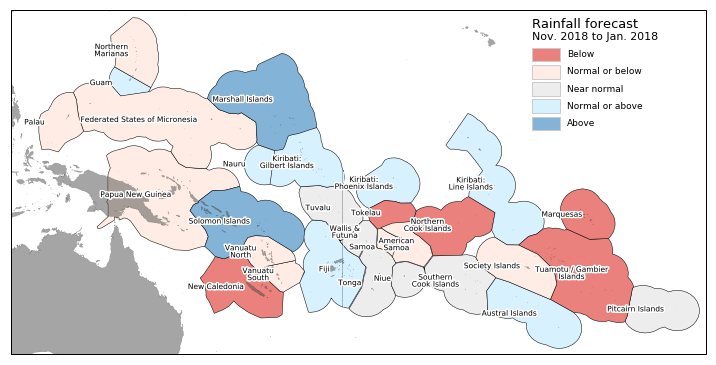

In [125]:
f, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=crs))

make_choropleth(ax, shape_gpd_m, dict_colors=outlook_rgb)

draw_Pacific(ax, extent = extent)

# ax.set_title('Current Heat Stress (Bleaching Area Index) for {:%B %Y}'.format(date))

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

text_transform = offset_copy(transform, units='dots', x=-25)

for i, row in shape_gpd.iterrows(): 
    cname = row.name_to_plot
    lon = row.lon
    lat = row.lat
    txt = ax.text(lon, lat, cname, color='k', verticalalignment='center', horizontalalignment='center',
                 transform=text_transform, fontsize=7.5)
    txt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='w')])

make_legend(ax, subtitle = 'Nov. 2018 to Jan. 2018')

ax.axvline(180, color='0.8', lw=0.5)

f.tight_layout()

ax.set_extent([125, 360-120, -32, 25], crs=ccrs.PlateCarree())

f.savefig('/Users/nicolasf/operational/ICU/bulletin/218_NDJ_2018_2019/images/ICU_rainfall_forecast_map_NDJ_2018_2019.png', dpi=200)

In [126]:
name = '/Users/nicolasf/operational/ICU/bulletin/218_NDJ_2018_2019/images/ICU_rainfall_forecast_map_NDJ_2018_2019.png'

In [128]:
!open {name}